In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import sklearn
!CUBLAS_WORKSPACE_CONFIG=:16:8

# !pip install memtorch
# import memtorch
# import copy
# from memtorch.mn.Module import patch_model
# from memtorch.map.Parameter import naive_map
# from memtorch.bh.crossbar.Program import naive_program

In [2]:
from tensorflow.python.client import device_lib
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device),'\n')
print('Device Details')
print(device_lib.list_local_devices())

Using cuda device 

Device Details
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12492653357477314075
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5074160288843367704
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [4]:
### Data Loading ## preictal 0, interictal 1
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)

rootPath = '/content/drive/MyDrive/ISML/SeizurePredictionDataset/'

patients = ['01']
dataset = 'CHBMIT'
dataType = 'features'
numFold = 5
bS = 32

if dataType == 'features':
  allData = np.empty((0,176))
  rawLabel = np.empty((0,),dtype=int)

for patient in patients:
  newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'synthetic_preictal.npy')
  allData = np.append(allData,newData,axis=0)
  rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
  newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'preictal.npy')
  allData = np.append(allData,newData,axis=0)
  rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
  newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'interictal.npy')
  allData = np.append(allData,newData,axis=0)
  rawLabel = np.append(rawLabel,np.ones((newData.shape[0],),dtype=int),axis=0)

allLabel = np.zeros((rawLabel.size, rawLabel.max()+1))
allLabel[np.arange(rawLabel.size),rawLabel] = 1

randInd = np.arange(0,len(allData))
np.random.shuffle(randInd)
allData = allData[randInd]
allLabel = allLabel[randInd]
allData = allData[:math.floor(allData.shape[0]/5)*5]
allLabel = allLabel[:math.floor(allLabel.shape[0]/5)*5]

pca = PCA(n_components=64)
allData = pca.fit_transform(allData)

foldsData = np.split(allData,numFold)
foldsLabel = np.split(allLabel,numFold)

trainData = np.concatenate(foldsData[0:-1])
trainLabel = np.concatenate(foldsLabel[0:-1])
testData = foldsData[-1]
testLabel = foldsLabel[-1]

trainData = np.expand_dims(trainData,1)
testData = np.expand_dims(testData,1)

trainData = torch.tensor(trainData)
testData = torch.tensor(testData)
trainLabel = torch.tensor(trainLabel)
testLabel = torch.tensor(testLabel)

In [5]:
### Network Definition
class ParallelConvolution(nn.Module):
    def __init__(self,size):
        super(ParallelConvolution, self).__init__()
        self.conv1 = nn.Conv1d(1,32,size)
        self.conv2 = nn.Conv1d(1,32,62-size)
        self.avgpool = nn.AvgPool1d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(1088,8)
        self.classification = nn.Linear(8,2)

    def forward(self,x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(x))
        x = torch.cat((out1, out2),dim=2)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        out = self.classification(x)
        return out
      
    

model = ParallelConvolution(27)
model = model.to(device)
#summary(model,(1,64))

In [ ]:
### Network convolution kernel size search 5 to 31

num_epoch = 50

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
kernel_size = [5,10,15,20,25,26,27,28,29,30,31]

loss_function = nn.BCEWithLogitsLoss()



for ker in kernel_size:
    print('--------------------------------')
    print(f'Kernel Size {ker}')
    print('--------------------------------')

    network = ParallelConvolution(ker)
    network.to(device,dtype=torch.float)

    optimizer = torch.optim.Adam(network.parameters())
    
    lossHist = []
    testAccHist = []
    trainAccHist = []
    bestAcc = 0
    bestSen = 0
    bestSpe = 0
    bestFPC = 1e10
    bestAUR = 0
    bestEpoch = [0,0,0,0,0]
    for epoch in range(num_epoch):
        trainCorrect = 0
        trainTotal = 0

        testCorrect = 0
        testTotal = 0

        trainOutputs = np.empty((0,1))
        trainLabels = np.empty((0,1))
        trainCM = np.zeros((2, 2))
        
        testOutputs = np.empty((0,1))
        testLabels = np.empty((0,1))
        testCM = np.zeros((2, 2))

        for i in range(0,len(trainData),bS):
            data = trainData[i:i+bS].to(device,dtype=torch.float)
            label = trainLabel[i:i+bS].to(device,dtype=torch.float)

            # Zero the gradients
            optimizer.zero_grad()
            network.eval()
            # Perform forward pass
            outputs = network(data)
            network.train()
            # Compute loss
            loss = loss_function(outputs, label)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            network.eval()
            # # Print statistics
            # current_loss += loss.item()

            outputs = outputs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            outputs = np.argmax(outputs,axis=1)
            label = np.argmax(label,axis=1)

            trainCM = np.add(trainCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

            trainCorrect += np.sum(outputs==label)
            trainTotal += len(outputs)

            trainOutputs = np.append(trainOutputs,outputs.reshape((-1,1)),axis=0)
            trainLabels = np.append(trainLabels,label.reshape((-1,1)),axis=0)

        for i in range(0,len(testData),bS):
            data = testData[i:i+bS].to(device,dtype=torch.float)
            label = testLabel[i:i+bS].to(device,dtype=torch.float)

            network.eval()
            # Perform forward pass
            outputs = network(data)
            #Caclulate statistics
            testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
            testTotal += len(outputs)
            #print(label)

            outputs = outputs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            outputs = np.argmax(outputs,axis=1)
            label = np.argmax(label,axis=1)

            testCM = np.add(testCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

            testCorrect += np.sum(outputs==label)
            testTotal += len(outputs)

            testOutputs = np.append(testOutputs,outputs.reshape((-1,1)),axis=0)
            testLabels = np.append(testLabels,label.reshape((-1,1)),axis=0)
            
        if testCorrect/testTotal > bestAcc:
            # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
            # bestAcc = testCorrect/testTotal
            torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/Scratch/Kernel{}Epoch{}'.format(ker,epoch))
            #print(network.state_dict())
            #print(testCorrect)

        trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
        trainAccuracy = trainCorrect/trainTotal
        trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
        trainSensitivity = trainTP / (trainTP+trainFN)
        trainSpecitivity = trainTN / (trainTN+trainFP)
        try:
          trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
        except:
          trainAUROC = 0.


        trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
        trainAccuracy = trainCorrect/trainTotal
        trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
        trainSensitivity = trainTP / (trainTP+trainFN)
        trainSpecitivity = trainTN / (trainTN+trainFP)
        try:
          trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
        except:
          trainAUROC = 0.


        testF1 = sklearn.metrics.f1_score(testLabels,testOutputs)
        testAccuracy = testCorrect/testTotal
        testTN, testFP, testFN, testTP = testCM.ravel()
        testSensitivity = testTP / (testTP+testFN)
        testSpecitivity = testTN / (testTN+testFP)
        try:
          testAUROC = sklearn.metrics.roc_auc_score(testLabels, testOutputs)
        except:
          testAUROC = 0.


        if testAccuracy > bestAcc:
          bestAcc = testAccuracy
          bestEpoch[0] = epoch
        if testSensitivity > bestSen:
          bestSen = testSensitivity
          bestEpoch[1] = epoch
        if testSpecitivity > bestSpe:
          bestSpe = testSpecitivity
          bestEpoch[2] = epoch
        if testFP < bestFPC:
          bestFPC = testFP
          bestEpoch[3] = epoch
        if testAUROC > bestAUR:
          bestAUR = testAUROC
          bestEpoch[4] = epoch

        print('Epoch:', epoch, 'Train Loss:', loss.item())
        print('Train Accuracy:', trainAccuracy, 'Train Sensitivity:', trainSensitivity, 'Train Specitivity:', trainSpecitivity, 'Train FP Count:', trainFP, 'Train AUROC:', trainAUROC)
        print('Test Accuracy:', testAccuracy, 'Test Sensitivity:', testSensitivity, 'Test Specitivity:', testSpecitivity, 'Test FP Count:', testFP, 'Test AUROC:', testAUROC,)
        print('\n')
        lossHist.append(loss)
        trainAccHist.append(trainCorrect/trainTotal)
        testAccHist.append(testCorrect/testTotal)

    plt.figure(1)
    plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure(2)
    plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.figure(3)
    plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch[0])
    print('Best Sensitivity:', bestSen, 'at epoch:', bestEpoch[1])
    print('Best Specitivity:', bestSpe, 'at epoch:', bestEpoch[2])
    print('Best FP Count:', bestFPC, 'at epoch:', bestEpoch[3])
    print('Best AUROC:', bestAUR, 'at epoch:', bestEpoch[4])

In [6]:
### 5-fold Cross Validation Function

def foldCrossValidation(patients,num_epoch=30):

  !CUBLAS_WORKSPACE_CONFIG=:16:8
  torch.manual_seed(8)
  np.random.seed(8)
  torch.backends.cudnn.benchmark = False
  torch.use_deterministic_algorithms(False)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(8)
  !CUBLAS_WORKSPACE_CONFIG=:16:8


  rootPath = '/content/drive/MyDrive/ISML/SeizurePredictionDataset/'

  dataset = 'CHBMIT'
  dataType = 'features'
  numFold = 5
  bS = 32

  if dataType == 'features':
    allData = np.empty((0,176))
    rawLabel = np.empty((0,),dtype=int)

  for patient in patients:
    newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'synthetic_preictal.npy')
    allData = np.append(allData,newData,axis=0)
    rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
    newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'preictal.npy')
    allData = np.append(allData,newData,axis=0)
    rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
    newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'interictal.npy')
    allData = np.append(allData,newData,axis=0)
    rawLabel = np.append(rawLabel,np.ones((newData.shape[0],),dtype=int),axis=0)

  allLabel = np.zeros((rawLabel.size, rawLabel.max()+1))
  allLabel[np.arange(rawLabel.size),rawLabel] = 1

  pca = PCA(n_components=64)
  allData = pca.fit_transform(allData)

  randInd = np.arange(0,len(allData))
  np.random.shuffle(randInd)
  allData = allData[randInd]
  allLabel = allLabel[randInd]
  allData = allData[:math.floor(allData.shape[0]/5)*5]
  allLabel = allLabel[:math.floor(allLabel.shape[0]/5)*5]

  foldsData = np.split(allData,numFold)
  foldsLabel = np.split(allLabel,numFold)


  def foldretrieve(fold,foldsData,foldsLabel):
      testData = foldsData[fold]
      testLabel = foldsLabel[fold]
      allData = foldsData[0:fold]+foldsData[fold:-1]
      allLabel = foldsLabel[0:fold]+foldsLabel[fold:-1]
      trainData = np.concatenate([*allData])
      trainLabel = np.concatenate([*allLabel])

      trainData = np.expand_dims(trainData,1)
      testData = np.expand_dims(testData,1)

      trainData = torch.tensor(trainData)
      testData = torch.tensor(testData)
      trainLabel = torch.tensor(trainLabel)
      testLabel = torch.tensor(testLabel)
      return trainData,testData,trainLabel,testLabel



  ker = 32

  loss_function = nn.BCEWithLogitsLoss()



  for fold in range(0,numFold):
      trainData,testData,trainLabel,testLabel = foldretrieve(fold,foldsData,foldsLabel)

      print('--------------------------------')
      print(f'Fold Number {fold}')
      print('--------------------------------')

      network = ParallelConvolution(ker)
      network.to(device,dtype=torch.float)

      optimizer = torch.optim.Adam(network.parameters())
      
      lossHist = []
      testAccHist = []
      trainAccHist = []
      bestAcc = 0
      bestSen = 0
      bestSpe = 0
      bestFPC = 1e10
      bestAUR = 0
      bestEpoch = [0,0,0,0,0]
      for epoch in range(num_epoch):
          trainCorrect = 0
          trainTotal = 0

          testCorrect = 0
          testTotal = 0

          trainOutputs = np.empty((0,1))
          trainLabels = np.empty((0,1))
          trainCM = np.zeros((2, 2))
          
          testOutputs = np.empty((0,1))
          testLabels = np.empty((0,1))
          testCM = np.zeros((2, 2))

          for i in range(0,len(trainData),bS):
              data = trainData[i:i+bS].to(device,dtype=torch.float)
              label = trainLabel[i:i+bS].to(device,dtype=torch.float)

              # Zero the gradients
              optimizer.zero_grad()
              network.eval()
              # Perform forward pass
              outputs = network(data)
              network.train()
              # Compute loss
              loss = loss_function(outputs, label)
              
              # Perform backward pass
              loss.backward()
              
              # Perform optimization
              optimizer.step()
              network.eval()
              # # Print statistics
              # current_loss += loss.item()

              outputs = outputs.cpu().detach().numpy()
              label = label.cpu().detach().numpy()

              outputs = np.argmax(outputs,axis=1)
              label = np.argmax(label,axis=1)

              trainCM = np.add(trainCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

              trainCorrect += np.sum(outputs==label)
              trainTotal += len(outputs)

              trainOutputs = np.append(trainOutputs,outputs.reshape((-1,1)),axis=0)
              trainLabels = np.append(trainLabels,label.reshape((-1,1)),axis=0)

          for i in range(0,len(testData),bS):
              data = testData[i:i+bS].to(device,dtype=torch.float)
              label = testLabel[i:i+bS].to(device,dtype=torch.float)

              network.eval()
              # Perform forward pass
              outputs = network(data)
              #Caclulate statistics
              testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              testTotal += len(outputs)
              #print(label)

              outputs = outputs.cpu().detach().numpy()
              label = label.cpu().detach().numpy()

              outputs = np.argmax(outputs,axis=1)
              label = np.argmax(label,axis=1)

              testCM = np.add(testCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

              testCorrect += np.sum(outputs==label)
              testTotal += len(outputs)

              testOutputs = np.append(testOutputs,outputs.reshape((-1,1)),axis=0)
              testLabels = np.append(testLabels,label.reshape((-1,1)),axis=0)
              
          if testCorrect/testTotal > bestAcc:
              # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              # bestAcc = testCorrect/testTotal
              torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpointCHBMITFeatures/Patient{}Fold{}Epoch{}'.format(patients[0],fold,epoch))
              #print(network.state_dict())
              #print(testCorrect)

          trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
          trainAccuracy = trainCorrect/trainTotal
          trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
          trainSensitivity = trainTP / (trainTP+trainFN)
          trainSpecitivity = trainTN / (trainTN+trainFP)
          try:
            trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
          except:
            trainAUROC = 0.


          trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
          trainAccuracy = trainCorrect/trainTotal
          trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
          trainSensitivity = trainTP / (trainTP+trainFN)
          trainSpecitivity = trainTN / (trainTN+trainFP)
          try:
            trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
          except:
            trainAUROC = 0.


          testF1 = sklearn.metrics.f1_score(testLabels,testOutputs)
          testAccuracy = testCorrect/testTotal
          testTN, testFP, testFN, testTP = testCM.ravel()
          testSensitivity = testTP / (testTP+testFN)
          testSpecitivity = testTN / (testTN+testFP)
          try:
            testAUROC = sklearn.metrics.roc_auc_score(testLabels, testOutputs)
          except:
            testAUROC = 0.


          if testAccuracy > bestAcc:
            bestAcc = testAccuracy
            bestEpoch[0] = epoch
          if testSensitivity > bestSen:
            bestSen = testSensitivity
            bestEpoch[1] = epoch
          if testSpecitivity > bestSpe:
            bestSpe = testSpecitivity
            bestEpoch[2] = epoch
          if testFP < bestFPC:
            bestFPC = testFP
            bestEpoch[3] = epoch
          if testAUROC > bestAUR:
            bestAUR = testAUROC
            bestEpoch[4] = epoch

          print('Epoch:', epoch, 'Train Loss:', loss.item())
          print('Train Accuracy:', trainAccuracy, 'Train Sensitivity:', trainSensitivity, 'Train Specitivity:', trainSpecitivity, 'Train FP Count:', trainFP, 'Train AUROC:', trainAUROC)
          print('Test Accuracy:', testAccuracy, 'Test Sensitivity:', testSensitivity, 'Test Specitivity:', testSpecitivity, 'Test FP Count:', testFP, 'Test AUROC:', testAUROC,)
          print('\n')
          lossHist.append(loss)
          trainAccHist.append(trainCorrect/trainTotal)
          testAccHist.append(testCorrect/testTotal)

      plt.figure(1)
      plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.figure(2)
      plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Train Accuracy')
      plt.legend()
      plt.figure(3)
      plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Test Accuracy')
      plt.legend()
      print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch[0])
      print('Best Sensitivity:', bestSen, 'at epoch:', bestEpoch[1])
      print('Best Specitivity:', bestSpe, 'at epoch:', bestEpoch[2])
      print('Best FP Count:', bestFPC, 'at epoch:', bestEpoch[3])
      print('Best AUROC:', bestAUR, 'at epoch:', bestEpoch[4])
  return None

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 87.04669189453125
Train Accuracy: 0.9007958287596048 Train Sensitivity: 0.7586431833007176 Train Specitivity: 0.9386620330147698 Train FP Count: 353.0 Train AUROC: 0.8515239158379
Test Accuracy: 0.9209659714599341 Test Sensitivity: 0.7435294117647059 Test Specitivity: 0.9749463135289907 Test FP Count: 35.0 Test AUROC: 0.9130928240377595


Epoch: 1 Train Loss: 10.446802139282227
Train Accuracy: 0.9441547749725576 Train Sensitivity: 0.8669755129053607 Train Specitivity: 0.9643413536437597 Train FP Count: 206.0 Train AUROC: 0.9146464050817613
Test Accuracy: 0.9456641053787047 Test Sensitivity: 0.8073170731707318 Test Specitivity: 0.9858356940509915 Test FP Count: 20.0 Test AUROC: 0.9446574902047369


Epoch: 2 Train Loss: 0.0
Train Accuracy: 0.962403951701427 Train Sensitivity: 0.9167785234899329 Train Specitivity: 0.9741290100034494 Train FP Count: 150.0 Train AUROC: 0.9397861937439773
Tes

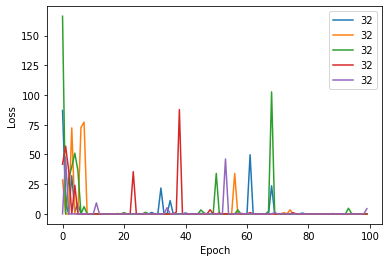

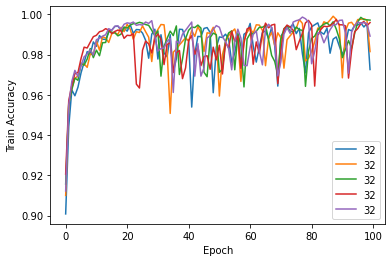

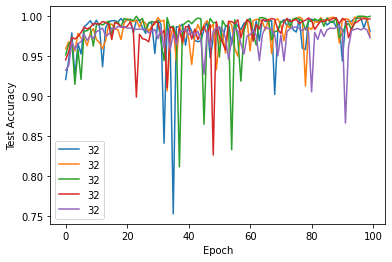

In [ ]:
##Patient 01
foldCrossValidation(['01'],num_epoch=100)

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 0.0
Train Accuracy: 0.9334577114427861 Train Sensitivity: 0.9635381498987171 Train Specitivity: 0.5826771653543307 Train FP Count: 53.0 Train AUROC: 0.7711570945945946
Test Accuracy: 0.9850746268656716 Test Sensitivity: 0.984 Test Specitivity: 1.0 Test FP Count: 0.0 Test AUROC: 0.9090909090909091


Epoch: 1 Train Loss: 0.0
Train Accuracy: 0.9794776119402985 Train Sensitivity: 0.987862440997977 Train Specitivity: 0.88 Train FP Count: 15.0 Train AUROC: 0.9246199324324325
Test Accuracy: 0.9875621890547264 Test Sensitivity: 0.9918918918918919 Test Specitivity: 0.9375 Test FP Count: 2.0 Test AUROC: 0.9518354274451835


Epoch: 2 Train Loss: 0.0
Train Accuracy: 0.9794776119402985 Train Sensitivity: 0.9885212694125591 Train Specitivity: 0.8740157480314961 Train FP Count: 16.0 Train AUROC: 0.9281883445945946
Test Accuracy: 0.9850746268656716 Test Sensitivity: 0.984 Test Specitivity: 1.0 Test FP 

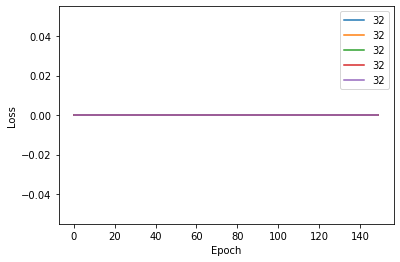

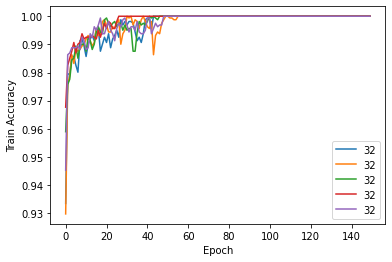

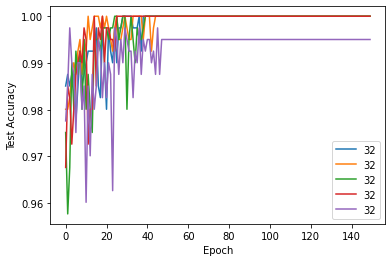

In [ ]:
##Patient 02
foldCrossValidation(['02'],num_epoch=150)

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 452.51605224609375
Train Accuracy: 0.8849881796690308 Train Sensitivity: 0.6485532815808045 Train Specitivity: 0.9325571489422121 Train FP Count: 475.0 Train AUROC: 0.794387799233381
Test Accuracy: 0.9607565011820332 Test Sensitivity: 1.0 Test Specitivity: 0.9553523399677246 Test FP Count: 83.0 Test AUROC: 0.8775811209439528


Epoch: 1 Train Loss: 99.80097961425781
Train Accuracy: 0.942080378250591 Train Sensitivity: 0.8265895953757225 Train Specitivity: 0.9646693046919164 Train FP Count: 250.0 Train AUROC: 0.8933472514325883
Test Accuracy: 0.9730496453900709 Test Sensitivity: 0.9607843137254902 Test Specitivity: 0.9751243781094527 Test FP Count: 45.0 Test AUROC: 0.9302499402056924


Epoch: 2 Train Loss: 0.0
Train Accuracy: 0.9612293144208038 Train Sensitivity: 0.8845598845598845 Train Specitivity: 0.9762510602205259 Train FP Count: 168.0 Train AUROC: 0.928419927545207
Test Accuracy: 0.

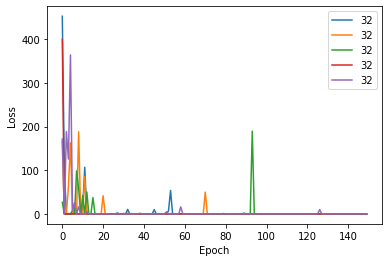

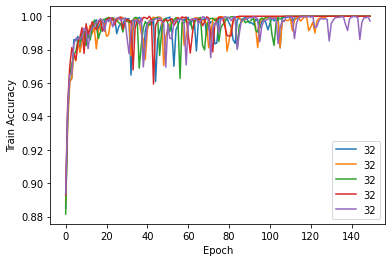

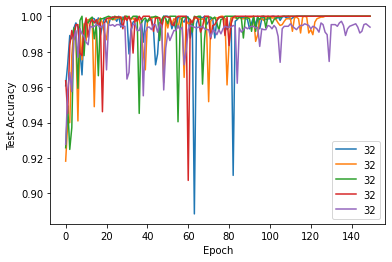

In [7]:
##Patient 03
foldCrossValidation(['03'],num_epoch=150)

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 476.705810546875
Train Accuracy: 0.829803328290469 Train Sensitivity: 0.6974262397991211 Train Specitivity: 0.8868741542625169 Train FP Count: 418.0 Train AUROC: 0.7991965565616143
Test Accuracy: 0.8872919818456884 Test Sensitivity: 0.7819548872180451 Test Specitivity: 0.9328277356446371 Test FP Count: 62.0 Test AUROC: 0.8712262235158735


Epoch: 1 Train Loss: 0.0
Train Accuracy: 0.8948562783661119 Train Sensitivity: 0.8152948801036941 Train Specitivity: 0.9276368491321763 Train FP Count: 271.0 Train AUROC: 0.8734709685636095
Test Accuracy: 0.840393343419062 Test Sensitivity: 0.6463195691202872 Test Specitivity: 0.9816993464052287 Test FP Count: 14.0 Test AUROC: 0.877380468873395


Epoch: 2 Train Loss: 0.0
Train Accuracy: 0.9107413010590015 Train Sensitivity: 0.8403090792015454 Train Specitivity: 0.9400267737617135 Train FP Count: 224.0 Train AUROC: 0.893762012808675
Test Accuracy: 0.93

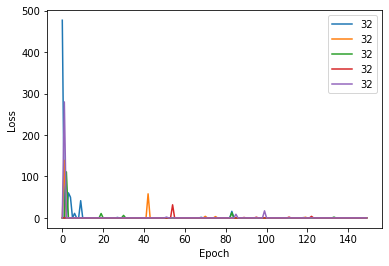

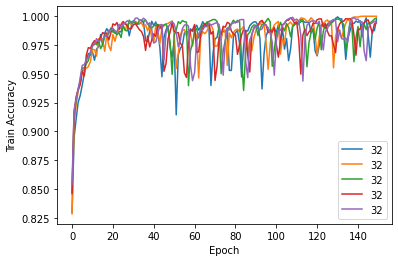

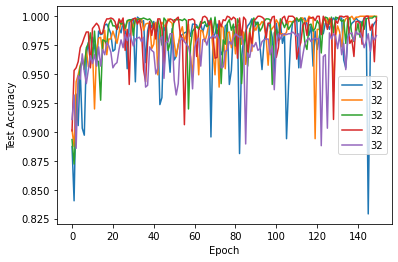

In [ ]:
##Patient 05
foldCrossValidation(['05'],num_epoch=150)

Streaming output truncated to the last 5000 lines.
Test Accuracy: 0.9518072289156626 Test Sensitivity: 0.9408602150537635 Test Specitivity: 0.9841269841269841 Test FP Count: 1.0 Test AUROC: 0.9218166251556662


Epoch: 8 Train Loss: 0.0
Train Accuracy: 0.9467871485943775 Train Sensitivity: 0.9625748502994012 Train Specitivity: 0.9146341463414634 Train FP Count: 28.0 Train AUROC: 0.9406740800183423
Test Accuracy: 0.9156626506024096 Test Sensitivity: 0.8934010152284264 Test Specitivity: 1.0 Test FP Count: 0.0 Test AUROC: 0.8561643835616438


Epoch: 9 Train Loss: 133.4818572998047
Train Accuracy: 0.9337349397590361 Train Sensitivity: 0.9521674140508222 Train Specitivity: 0.8960244648318043 Train FP Count: 34.0 Train AUROC: 0.925433910351943
Test Accuracy: 0.9317269076305221 Test Sensitivity: 0.9162303664921466 Test Specitivity: 0.9827586206896551 Test FP Count: 1.0 Test AUROC: 0.8875700498132004


Epoch: 10 Train Loss: 42.89586639404297
Train Accuracy: 0.9357429718875502 Train Sensitivity:

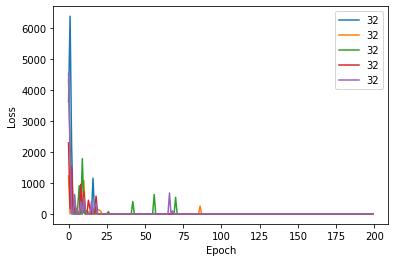

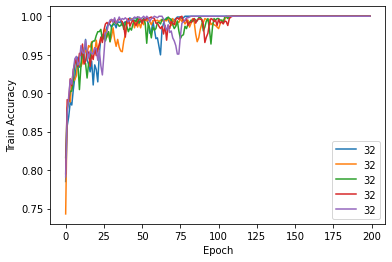

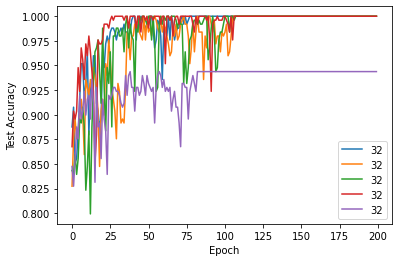

In [ ]:
##Patient 08
foldCrossValidation(['08'],num_epoch=200)